### Topic of this notebook: Police retaliation against racial injustice protests

This notebook includes all the techniques used and findings that we analyze throughout the report.
The structure is the following:
1. Data Wrangling: XXX
2. Visualization: XXX
3. Regression Analysis: XXX

In [116]:
# Import libraries we will need

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')

### Data Wrangling

The user of this notebook does not have to run the following cell. We use this code to load and keep traffic stop data with date higher than 2017-01-01. We do that as the initial county traffic stop data, provided by the "Stanford Open Policing Project" (https://openpolicing.stanford.edu/data/), is quite large in terms of size and therefore, we reduced the size (up to 80% less) and re-saved it to make the overall size of this repository smaller.

In [117]:
def select_time_frame(df, date):
    df.date = pd.to_datetime(df.date)
    df = df[df['date'] > pd.to_datetime(date)]
    return df

# a quick example of select_time_frame
# df_fl_state = pd.read_csv('data/states/yg821jf8611_ca_los_angeles_2020_04_01.csv.zip', compression='zip')
# df_fl_state  = select_time_frame(df_fl_state, '2017-01-01')
# df_fl_state.to_csv('data/states/ca_los_angeles_2020_04_01.csv.gz', compression='gxzip')

##### 1) Load, parse, filter and sort Count Love data set based on the number of protest attendees

"Count Love" data set is a collection of different types of protests that took place in the USA from 2017 to 2020 and it has been used as a point of reference in several projects (to name a few: New York Times, Bloomberg, ACLED data project, Boston University Research).

Count Love source: https://countlove.org/faq.html

In [118]:
# load and visualize the fetures of the data set
df_protests = pd.read_csv('data/protests.csv')
df_protests.sample(2)

,Date,Location,Attendees,Event,Tags,Curated,Source,Total Articles
31397,2020-07-19,"Rochester, NY",300.0,Racial Injustice,Civil Rights; For racial justice; For greater ...,Yes,https://www.wxxinews.org/post/hundreds-protest...,7
13951,2018-08-27,"Albuquerque, NM",50.0,Immigration,Immigration; For compassionate immigration,Yes,https://www.abqjournal.com/1213802/protest-aga...,1


The initial trasformation of the protest data set includes the following steps:
1. Filter protests according to Event column and keep only 'Racial Injustice' protests.
2. Convert Date column to datetime for future computations.
3. Keep only protests with date falling in the timeframe: 2017-01-01 < date < 2019-01-01.
4. Sort protests based on the number of attendees.

In [119]:
# Filter racial injustice protests
df_protests = df_protests[df_protests['Event'].str.contains('Racial Injustice')]

# Convert Date column to datetime
df_protests['Date'] = pd.to_datetime(df_protests['Date'])

# Select protests between 2017-01-01 and 2019-01-01
df_protests = df_protests[(df_protests['Date'] >= pd.to_datetime('2017-01-01')) &
                         (df_protests['Date'] < pd.to_datetime('2019-01-01'))]

# Sort protests based on attendess
df_protests = df_protests.sort_values('Attendees',ascending=False)

# pd.set_option('display.max_rows', df_protests.shape[0]+1)
df_protests.head(2)

,Date,Location,Attendees,Event,Tags,Curated,Source,Total Articles
6875,2018-01-15,"San Antonio, TX",300000.0,Racial Injustice (Martin Luther King Jr.),Civil Rights; For racial justice; Martin Luthe...,Yes,http://www.kens5.com/news/mlk-march-wrap-up/50...,6
4714,2017-08-19,"Boston, MA",40000.0,Racial Injustice (Counter Protest; Alt-Right/N...,Civil Rights; For racial justice; Against whit...,Yes,http://www.waow.com/story/36173262/2017/08/19/...,144


#### 2) Select top 3 largest racial injustice protests in USA

Now that we computed the largest racial injustice protests based on the Count Love dataset, we use the summary tables provided in the website of the original paper (https://openpolicing.stanford.edu/data/) in order to find traffic stop data that matches the time period of the largest protests. Based on this table we found available data for the following protests:

1. index=6875, Date=2018-01-15, Location=San Antonio-TX, Attendees=300000
2. index=4634, Date=2017-08-16, Location=Philadelphia-PA, Attendees=2000
3. index=4353, Date=2017-08-13, Location=Los Angeles-CA, Attendees=1500

#### Stanford data from 12 largest protests  

In [120]:
stop_dataset_names = ['tx_san_antonio','pa_philadelphia','ca_los_angeles',
                      'ca_oakland','la_new_orleans','ky_louisville',
                      'tx_houston','pa_pittsburgh', 'vt_burlington',
                      'wi_madison','tn_nashville']
df_stops = []

for name in stop_dataset_names:
    if name == 'tn_nashville':
        dir_ = f'data/states/{name}_2020_04_01.csv.zip'
    else:
        dir_ = f'data/states/{name}_2020_04_01.csv.gz'
    df_stops.append(pd.read_csv(dir_, compression='gzip'))

In [130]:
def prepare_df_for_merge(df, state, city):
    df = df[df['type'] == 'vehicular']
    df = df[(df['subject_race']=='black') | (df['subject_race']=='white')]
    df = df.groupby(['date','subject_race']).size().reset_index(name='stops')
    df = df.rename(columns={"subject_race": "race"})
    
    df['state'] = state
    df['city'] = city
    
    return df

state = ['Texas', 'Pennsylvania', 'California', 'California', 'Louisiana',
         'Kentucky', 'Texas', 'Pennsylvania', 'Vermont', 'Wisconsin', 'Tennessee']

city = ['San Antonio', 'Philadelphia', 'Los Angeles', 'Oakland', 'New Orleans',
        'Louisville', 'Houston', 'Pittsburgh', 'Burlington', 'Madison', 'Nashville']

df_stops_grouped = []
for county_data in zip(df_stops, state, city):
    df_stops_grouped.append(prepare_df_for_merge(county_data[0], county_data[1], county_data[2]))
    
traffic_stops_df = pd.concat(df_stops_grouped, axis=0)
print(traffic_stops_df.columns)

Index(['date', 'race', 'stops', 'state', 'city'], dtype='object')


In [131]:
print(traffic_stops_df.city.unique())
traffic_stops_df.head() 

['San Antonio' 'Philadelphia' 'Los Angeles' 'Oakland' 'New Orleans'
 'Louisville' 'Houston' 'Pittsburgh' 'Burlington' 'Madison' 'Nashville']


,date,race,stops,state,city
0,2017-01-02,black,29,Texas,San Antonio
1,2017-01-02,white,95,Texas,San Antonio
2,2017-01-03,black,39,Texas,San Antonio
3,2017-01-03,white,117,Texas,San Antonio
4,2017-01-04,black,22,Texas,San Antonio


In [132]:
#data from: https://www.census.gov/
#San Antonio, 2019: pop: 1,547,253 / white: 24.8%, black: 6.9%, hispanic: 64.2%
#Philadelphia, 2019: pop: 1,584,064 / white: 34.6%, black: 42.3%,  Latino: 14.5%
#Los Angeles,2019: 3,979,576 / white: 28.5%, black: 8.9%, Latino: 48.6%
# 4. Oakland-CA, 2019: 433,031 / white: 28.3%, black: 23.8%
# 5. New Orleans-LA, 2019: 390,144 / white: 30.7%, black: 59.5%
# 6. Houston-TX, 2019: 2,320,268/ white:24.4%, black: 22.6%
# 7. Louisville-KY, 2019: 617,638/ white:65.6%, black: 23.6% 
# 8. pittsburgh-PA, 2019: 300,286/ white:64.7%, black: 23.0% 
# 9. burlington-vt, 2019: 42,819/ white:82.9%, black: 5.7% 
# 10. madison-wi, 2019: 259,680/ white:73.6%, black: 7.0%

#['Florida_state_wide','FL', 'white', 21477737*0.532, 0.532],
#['Florida_state_wide','FL', 'black', 259680*0.169, 0.169],


#df_census_data = df_census[df_census['state']=='Florida'].drop(['POPESTIMATE2016','POPESTIMATE2017', 'POPESTIMATE2018'],axis=1)
#df_census_data = df_census_data.rename(columns={"POPESTIMATE2019": "census_2019"})

#put into a CSV file
df_hard_coded_city_census = pd.DataFrame([['San Antonio','TX', 'white', 1547253*0.248,  0.248], 
                                          ['San Antonio','TX', 'black', 1547253*0.069, 0.069 ],
                                          ['Philadelphia','PA', 'white', 1584064*0.346, 0.346],
                                          ['Philadelphia','PA', 'black', 1584064*0.423, 0.423 ],
                                          ['Los Angeles','CA', 'white', 3979576*0.285, 0.285 ],
                                          ['Los Angeles','CA', 'black', 3979576*0.089, 0.089],
                                          ['Oakland','CA', 'white', 433031*0.283, 0.283],
                                          ['Oakland','CA', 'black', 433031*0.238, 0.238],
                                          ['New Orleans','LA', 'white', 390144*0.307, 0.307],
                                          ['New Orleans','LA', 'black', 390144*0.595, 0.595],
                                          ['Houston','TX', 'white', 2320268*0.244, 0.244],
                                          ['Houston','TX', 'black', 2320268*0.226, 0.226],
                                          ['Louisville','KY', 'white', 617638*0.656, 0.656],
                                          ['Louisville','KY', 'black', 617638*0.236, 0.236],
                                          ['Pittsburgh','PA', 'white', 300286*0.647, 0.647],
                                          ['Pittsburgh','PA', 'black', 300286*0.23, 0.23],
                                          ['Burlington','VT', 'white', 42819*0.829, 0.647],
                                          ['Burlington','VT', 'black', 42819*0.057, .057],
                                          ['Madison','WI', 'white', 259680*0.736, 0.736],
                                          ['Madison','WI', 'black', 259680*0.070, .070],
                                          ['Nashville','TN', 'white',  670820*0.554, 0.554],
                                          ['Nashville','TN', 'black', 670820*0.276, .276],  
                                         ],
                                         columns=['city', 'short_state', 'race', 'census_2019', 'percentage'])


#traffic_stops_census = pd.merge(traffic_stops_df, df_census_data[df_census_data['state']=='Florida'], how='left', on=['state', 'race'])
traffic_stops_census = pd.merge(traffic_stops_df, df_hard_coded_city_census, how='inner', on=['city', 'race'])
traffic_stops_census.date = pd.to_datetime(traffic_stops_census.date)
print(len(traffic_stops_census))

10191


In [133]:
#data cleaning code for merge to trafic stop data
df_protests['Location'] = [loc.replace('South ','') if 'South ' in loc else  loc for loc in df_protests.Location.tolist()]
df_protests['Location'] = [loc.replace('Carl Braden Memorial Center, West ','') if 'Carl Braden Memorial Center, West ' in loc else  loc for loc in df_protests.Location.tolist()]
df_protests['Location'] = [', '.join(loc.split(', ')[-2:]) if len(loc.split(', ')) >2 else loc for loc in df_protests.Location.tolist()]


df_protests['city'] = [loc.split(', ')[0] for loc in df_protests.Location.tolist()]
df_protests['state'] = [loc.split(', ')[-1] for loc in df_protests.Location.tolist()]


df_prot_merge = df_protests.rename(columns={"Date": "date"})
df_prot_merge = df_prot_merge.rename(columns={"state": "short_state"})
print(len(df_prot_merge))


df_merged_city = pd.merge(traffic_stops_census, df_prot_merge, how='inner', on=['date', 'city',  'short_state'])
df_merged_city = df_merged_city.drop_duplicates()


print(len(df_merged_city))


df_merged_city.sort_values(by=['Attendees', 'Location'], inplace=True, ascending=[1,0])
print(len(df_merged_city))
df_merged_city = df_merged_city[df_merged_city['Attendees']>0]
print(len(df_merged_city))
df_merged_city.head(10)

print(len(df_merged_city.Source.unique()))

#San Diego 4
#Denver 3
#Cincinnati 3
#Nashville 8
print(df_merged_city.columns)

1633
162
162
119
56
Index(['date', 'race', 'stops', 'state', 'city', 'short_state', 'census_2019',
       'percentage', 'Location', 'Attendees', 'Event', 'Tags', 'Curated',
       'Source', 'Total Articles'],
      dtype='object')


In [134]:
selected_protests = df_merged_city[['date','Location','Attendees','Event',
                                 'Tags','Curated','Source','Total Articles',
                                 'city','state']].sort_values(by='Attendees', ascending=False).head(12).reset_index()


selected_protests['start_date'] = pd.to_datetime(['2018-01-07', '2018-01-07', 
                                                  '2017-08-09', '2017-08-09',
                                                  '2017-08-06', '2017-08-06',
                                                  '2018-02-24', '2018-02-24',
                                                  '2017-08-12', '2017-08-12',
                                                  '2017-08-12', '2017-08-12'])
selected_protests['end_date'] = pd.to_datetime(['2018-01-21', '2018-01-21', 
                                                '2017-08-22', '2017-08-22', 
                                                '2017-08-19', '2017-08-19',
                                                '2018-03-10', '2018-03-10',
                                                '2017-08-26', '2017-08-26',
                                                '2017-08-26', '2017-08-26'])
selected_protests

,index,date,Location,Attendees,Event,Tags,Curated,Source,Total Articles,city,state,start_date,end_date
0,11,2018-01-15,"San Antonio, TX",300000.0,Racial Injustice (Martin Luther King Jr.),Civil Rights; For racial justice; Martin Luthe...,Yes,http://www.kens5.com/news/mlk-march-wrap-up/50...,6,San Antonio,Texas,2018-01-07,2018-01-21
1,10,2018-01-15,"San Antonio, TX",300000.0,Racial Injustice (Martin Luther King Jr.),Civil Rights; For racial justice; Martin Luthe...,Yes,http://www.kens5.com/news/mlk-march-wrap-up/50...,6,San Antonio,Texas,2018-01-07,2018-01-21
2,25,2017-08-16,"Philadelphia, PA",2000.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://6abc.com/philly-is-charlottesville-marc...,16,Philadelphia,Pennsylvania,2017-08-09,2017-08-22
3,24,2017-08-16,"Philadelphia, PA",2000.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://6abc.com/philly-is-charlottesville-marc...,16,Philadelphia,Pennsylvania,2017-08-09,2017-08-22
4,65,2017-08-13,"Los Angeles, CA",1500.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://mynewsla.com/life/2017/08/13/southern-c...,9,Los Angeles,California,2017-08-06,2017-08-19
5,64,2017-08-13,"Los Angeles, CA",1500.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://mynewsla.com/life/2017/08/13/southern-c...,9,Los Angeles,California,2017-08-06,2017-08-19
6,125,2018-03-03,"Houston, TX",1000.0,Racial Injustice,Civil Rights; For racial justice,Yes,https://www.chron.com/news/houston-texas/houst...,2,Houston,Texas,2018-02-24,2018-03-10
7,124,2018-03-03,"Houston, TX",1000.0,Racial Injustice,Civil Rights; For racial justice,Yes,https://www.chron.com/news/houston-texas/houst...,2,Houston,Texas,2018-02-24,2018-03-10
8,95,2017-08-19,"New Orleans, LA",1000.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://www.theadvocate.com/new_orleans/news/ar...,13,New Orleans,Louisiana,2017-08-12,2017-08-26
9,94,2017-08-19,"New Orleans, LA",1000.0,Racial Injustice (Charlottesville),Civil Rights; For racial justice; Against whit...,Yes,http://www.theadvocate.com/new_orleans/news/ar...,13,New Orleans,Louisiana,2017-08-12,2017-08-26


In [135]:
traffic_stops_census = traffic_stops_census.assign(key=1)
selected_protests = selected_protests.assign(key=1)
traffic_stops_census_protests = pd.merge(traffic_stops_census, selected_protests, on='key').drop('key',axis=1)
print(traffic_stops_census_protests.columns)
traffic_stops_census_protests = traffic_stops_census_protests.query('(date_x >= start_date and date_x <= end_date) and state_x == state_y')
traffic_stops_census_protests.head()
traffic_stops_census_protests['elapsed_time'] = pd.to_numeric((traffic_stops_census_protests['date_x'] - 
                                                               traffic_stops_census_protests['date_y']).dt.days,
                                                               downcast='integer')
traffic_stops_census_protests['search_rate'] = traffic_stops_census_protests['stops'] / traffic_stops_census_protests['census_2019']

Index(['date_x', 'race', 'stops', 'state_x', 'city_x', 'short_state',
       'census_2019', 'percentage', 'index', 'date_y', 'Location', 'Attendees',
       'Event', 'Tags', 'Curated', 'Source', 'Total Articles', 'city_y',
       'state_y', 'start_date', 'end_date'],
      dtype='object')


## New Data Tryout

In [136]:
#NEW FROM AUREl
#Second Data Set Test
df_protests = pd.read_csv('data/test_data_blm_protests/BLM_cities.csv')
df_cities = pd.read_csv('data/test_data_blm_protests/BLM_protests_2014.08.09-2015.08.09.csv')
df_merged_blm_protests = pd.merge(df_protests, df_cities, how='inner', on=['FIPS'])
print(len(df_merged_blm_protests))


674


In [139]:
def prepare_df_for_merge(df, city):
    df = df[df['type'] == 'vehicular']
    df = df[(df['subject_race']=='black') | (df['subject_race']=='white')]
    df = df.groupby(['date','subject_race']).size().reset_index(name='stops')
    df = df.rename(columns={"subject_race": "race"})
    #df['state'] = state
    df['city'] =city
    
    return df


df_la= pd.read_csv('data/states_newdata/ca_los_angeles_2020_04_01.csv.gz', compression='gzip')
df_ci= pd.read_csv('data/states_newdata/il_chicago_2020_04_01.csv.gz', compression='gzip')
df_bl= pd.read_csv('data/states_newdata/md_baltimore_2020_04_01.csv.gz', compression='gzip')
df_ph= pd.read_csv('data/states_newdata/pa_philadelphia_2020_04_01.csv.gz', compression='gzip')
df_md= pd.read_csv('data/states_newdata/wi_madison_2020_04_01.csv.gz', compression='gzip')
df_sp= pd.read_csv('data/states_newdata/mn_saint_paul_2020_04_01.csv.gz', compression='gzip')
df_oak = pd.read_csv('data/states_newdata/ca_oakland_2020_04_01.csv.gz', compression='gzip')




df_la = prepare_df_for_merge(df_la, 'Los Angeles')
df_oak = prepare_df_for_merge(df_oak, 'Oakland')
df_ci = prepare_df_for_merge(df_ci, 'Chicago')
#df_bl = prepare_df_for_merge(df_bl, 'Baltimore')
df_ph = prepare_df_for_merge(df_ph, 'Philadelphia')

df_md = prepare_df_for_merge(df_md, 'Madison')
df_sp = prepare_df_for_merge(df_sp, 'Saint Paul')
#data merge
traffic_stops_df_blm = pd.concat([df_la, df_oak, df_md, df_ci, df_bl, df_ph, df_sp], axis=0)

traffic_stops_df_blm = traffic_stops_df_blm.drop(['raw_row_number', 'time','Unnamed: 0', 'time', 'district', 
                                          'officer_id_hash', 'beat', 'citation_issued', 'outcome', 'type'], axis=1)

In [140]:
# Merge stops with census
traffic_stops_df_blm['date'] = pd.to_datetime(traffic_stops_df_blm.date)
df_merged_blm_protests['date'] = pd.to_datetime(df_merged_blm_protests.date)

df_merged_traffic_BLM = pd.merge(df_merged_blm_protests, traffic_stops_df_blm, how='inner', on=['city', 'date'])
print(len(df_merged_traffic_BLM))


#NOT VERY NICE CHANGE IF HAVE TIME
race_of_interest_percentage = []
tot_pop = df_merged_traffic_BLM.TotalPop.tolist()
black_pop = df_merged_traffic_BLM.BlackPop.tolist()
white_pop = df_merged_traffic_BLM.WhitePop.tolist()
race_of_obsevation = df_merged_traffic_BLM.race.tolist()
for idx, race in enumerate(race_of_obsevation):
    if race == 'white':
        race_of_interest_percentage.append(white_pop[idx]/tot_pop[idx])
    elif race == 'black':
        race_of_interest_percentage.append(black_pop[idx]/tot_pop[idx])
    else:
        print('jjjjjjjjj')

df_merged_traffic_BLM['race_of_interest_percentage'] = race_of_interest_percentage


df_merged_traffic_BLM = df_merged_traffic_BLM[df_merged_traffic_BLM['popnum'].notna()]
df_merged_traffic_BLM.columns

154


Index(['Unnamed: 0', 'FIPS', 'Geography.x', 'TotalPop', 'PovertyRate',
       'BlackPop', 'BlackPovertyRate', 'AsianPop', 'AsianPoverty',
       'HispanicPop', 'HispanicPoverty', 'WhitePop', 'WhitePovertyRate',
       'PercentBachelor.s', 'State..FIPS.', 'Place..FIPS.', 'Area.Name',
       'SqMiles', 'tot.protests', 'tot.attend', 'deaths', 'deaths_unarmed',
       'deaths_unarmed_black', 'deaths_armed_black', 'deaths_black',
       'deaths_protestyear', 'deaths_protestyear_unarmed', 'X.x', 'NAACPyears',
       'MayorPartisanship', 'blackmayor', 'FIPS_PLACE', 'dem', 'rep',
       'dem_share', 'FIPS_ST', 'X.y', 'pop', 'hbcu', 'hbcu2', 'crime',
       'deathduring', 'per_ba', 'Per_Black', 'pop.density', 'collegeenrollpc',
       'mayorrep', 'unarmed_deaths_pc', 'deaths_pc', 'unarmed_deaths_black_pc',
       'deaths_black_pc', 'anyprotests', 'url', 'url2', 'loc', 'city', 'ST',
       'intl', 'date', 'popnum', 'race', 'stops',
       'race_of_interest_percentage'],
      dtype='object')

### Visualization 

In [141]:
def my_init(loc=-0.5):
    ''' Function to initialize the plot. Creates two subplots on white background,
    sets x and y limits, and draws the vertical line'''
    sns.set_theme(context='notebook', style='white', font='sans-serif')
    fig, axs = plt.subplots(ncols=4, nrows=2, sharey=False, figsize=(20,12))
    for ax in axs.flatten():
        ax.set_xlim(-8,9)
        ax.axvline(loc, color='black', ls='--', lw=0.9)
    return axs

In [142]:
def my_lineplot(data, ax):
    ''' Function that plots the lineplot in the desired colors and width'''
    sns.lineplot(data=data, x='elapsed_time', y='search_rate', hue='race',
                 palette=['blue', 'red'], ci=0, lw=0.9, ax=ax).legend_.remove()

In [143]:
def my_ticker(ax, ylabel=False):
    ''' Function to set the desired x and y ticks. Selects desired ticks
    and values to show, renames the axes'''
    if ylabel:
        ax.set_xlabel('')
        ax.set_ylabel('Search rate (%)')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')

In [144]:
def my_title(txt, ax):
    ''' Function that recreates the title style of the plot. It creates a block
    in color silver and adds text on it'''
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="11%", pad=0)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_facecolor('silver')
    at = AnchoredText(txt, loc=10, prop={'backgroundcolor':'silver',
                      'size':10, 'color':'black'}, frameon=False)
    cax.add_artist(at)    

In [145]:
def my_legend(ax):
    ''' Function that draws legend.'''
    legend_elements = [Patch(facecolor='silver', edgecolor='red', linewidth=0.,
                             linestyle='--', label='White drivers', hatch=r'--'), #color='blue'
                       Patch(facecolor='silver', edgecolor='blue', linewidth=0.,
                             linestyle='--', label='Black drivers', hatch=r'--'), #color='black'
                      ] 
    ax.legend(handles=legend_elements, loc="best", frameon=False,
               bbox_to_anchor=(0.44, 0.44, 0.52, 0.5))

In [146]:
def my_regplot(data, ax, ci, color, truncate=True):
    ''' Function to create the underlaying regression plot.'''
    sns.regplot(data=data, x='elapsed_time', y='search_rate', ci=ci, scatter=False, 
                line_kws = {'linestyle':'--', 'color':color, 'lw':1}, truncate=truncate, 
                ax=ax)

### Dataset 1

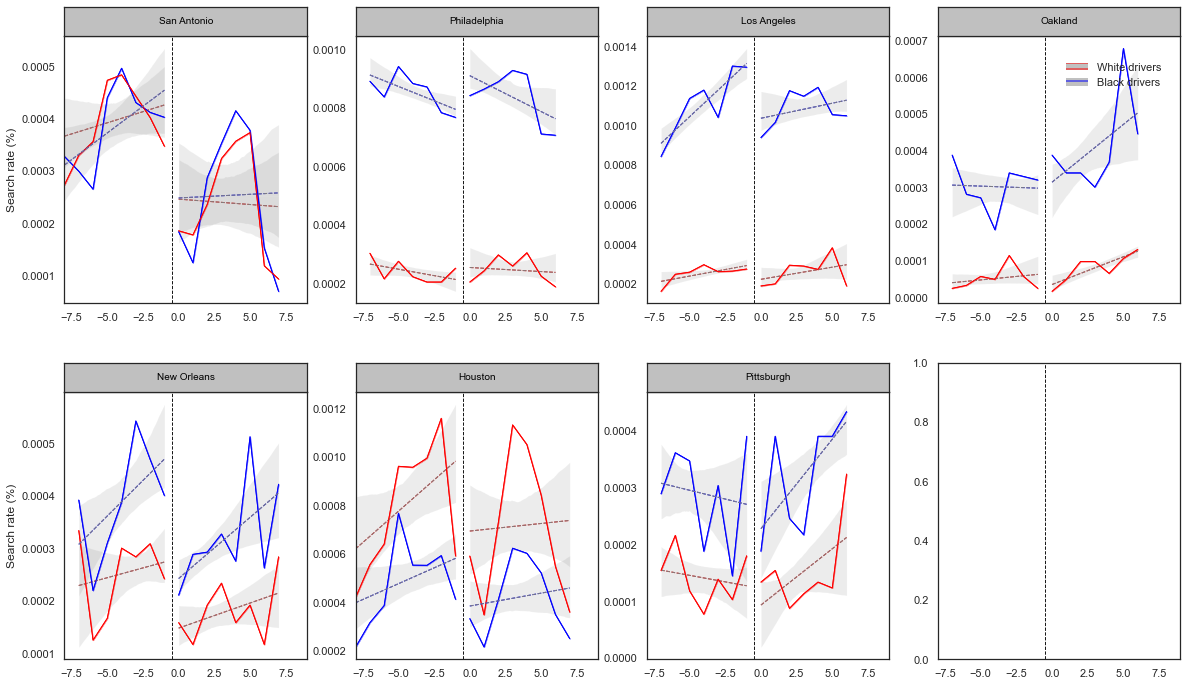

In [147]:
axs = my_init()
colors = {'white':'red', 'black':'blue'}

data = traffic_stops_census_protests
axs = axs.flatten()

for i,city in enumerate(data.city_x.unique()):
    for race in ['white', 'black']:
        first_half = data[data.city_x == city]
        first_half = first_half[first_half.elapsed_time >= 0]
        my_lineplot(first_half, axs[i])
        my_regplot(first_half[first_half.race == race], axs[i], 0, colors[race]) # plotting dashed line
        my_regplot(first_half[first_half.race == race], axs[i], 95, 'grey') # plotting grey background

        second_half = data[data.city_x == city]
        second_half = second_half[second_half.elapsed_time < 0]
        my_lineplot(second_half, axs[i])
        my_regplot(second_half[second_half.race == race], axs[i], 0, colors[race]) # plotting dashed line
        my_regplot(second_half[second_half.race == race], axs[i], 95, 'grey') # plotting grey background

    
    my_title(city, axs[i])
    my_ticker(axs[i])
    
my_ticker(axs[0], ylabel=True)
my_ticker(axs[4], ylabel=True)
my_legend(axs[3])

## Dataset 2

In [148]:

selected_protests = df_merged_traffic_BLM[['date','city','popnum','race', 'TotalPop']].sort_values(by='popnum', ascending=False).head(12).reset_index()

import datetime
selected_protests['start_date'] = [date - datetime.timedelta(days=7) for date in selected_protests['date']]
selected_protests['end_date'] = [date + datetime.timedelta(days=7) for date in selected_protests['date']]
traffic_stops_df_blm = traffic_stops_df_blm.assign(key=1)
selected_protests = selected_protests.assign(key=1)
traffic_stops_census_protests = pd.merge(traffic_stops_df_blm, selected_protests, on='key').drop('key',axis=1)

traffic_stops_census_protests = traffic_stops_census_protests.query('(date_x >= start_date and date_x <= end_date) and city_x == city_y')

traffic_stops_census_protests['elapsed_time'] = pd.to_numeric((traffic_stops_census_protests['date_x'] - 
                                                               traffic_stops_census_protests['date_y']).dt.days,
                                                               downcast='integer')
traffic_stops_census_protests['search_rate'] = traffic_stops_census_protests['stops'] / traffic_stops_census_protests['TotalPop']
traffic_stops_census_protests['race'] = traffic_stops_census_protests['race_x'] 

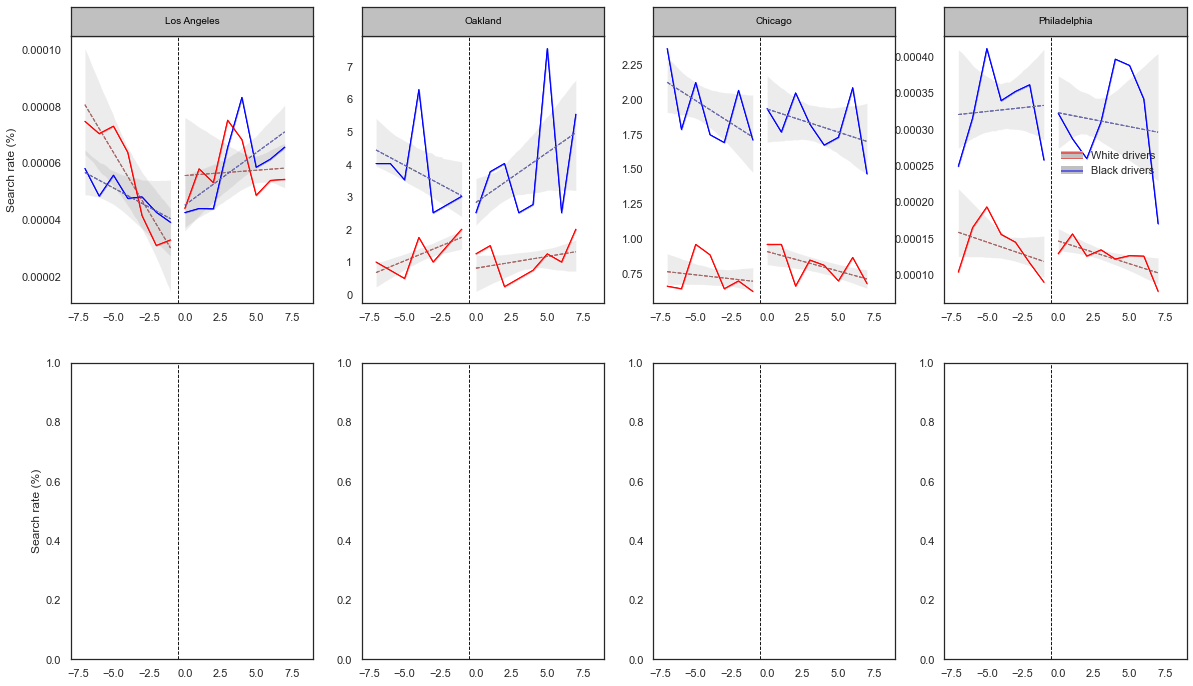

In [149]:
axs = my_init()
colors = {'white':'red', 'black':'blue'}

data = traffic_stops_census_protests
axs = axs.flatten()

for i,city in enumerate(data.city_x.unique()):
    for race in ['white', 'black']:
        first_half = data[data.city_x == city]
        first_half = first_half[first_half.elapsed_time >= 0]
        my_lineplot(first_half, axs[i])
        my_regplot(first_half[first_half.race == race], axs[i], 0, colors[race]) # plotting dashed line
        my_regplot(first_half[first_half.race == race], axs[i], 95, 'grey') # plotting grey background

        second_half = data[data.city_x == city]
        second_half = second_half[second_half.elapsed_time < 0]
        my_lineplot(second_half, axs[i])
        my_regplot(second_half[second_half.race == race], axs[i], 0, colors[race]) # plotting dashed line
        my_regplot(second_half[second_half.race == race], axs[i], 95, 'grey') # plotting grey background

    
    my_title(city, axs[i])
    my_ticker(axs[i])
    
my_ticker(axs[0], ylabel=True)
my_ticker(axs[4], ylabel=True)
my_legend(axs[3])

### Regression

In [150]:
from datetime import datetime, timedelta

def calculateMeanPrePost(number_days):
    dates_of_interest = df_merged_city.date.tolist()
    city_of_interest = df_merged_city.city.tolist()
    race_of_interest = df_merged_city.race.tolist()
    event_name = df_merged_city.Event.tolist()
    source = df_merged_city.Source.tolist()

    pre_days_average = []
    post_days_average = []
    colum = ['date', 'city', 'Event', 'Source', 'race', 'period', 'x_days_stop_mean']
    for idx, date in enumerate(dates_of_interest):
        #Pre period
        pre = traffic_stops_census[(traffic_stops_census['date']>date - timedelta(days=number_days))& (traffic_stops_census['date']<date) 
                                   & (traffic_stops_census['city']==city_of_interest[idx]) & (traffic_stops_census['race']==race_of_interest[idx])]
        pre_days_average.append([date, city_of_interest[idx], event_name[idx], source[idx], race_of_interest[idx],0,pre.stops.mean()])

        #Post period
        post = traffic_stops_census[(traffic_stops_census['date']<date + timedelta(days=number_days))& (traffic_stops_census['date']>date) 
                                   & (traffic_stops_census['city']==city_of_interest[idx]) & (traffic_stops_census['race']==race_of_interest[idx])]
        post_days_average.append([date, city_of_interest[idx], event_name[idx], source[idx], race_of_interest[idx],1 ,post.stops.mean()])



    df_pre_post_stops = pd.concat([pd.DataFrame(pre_days_average, columns=colum), 
            pd.DataFrame(post_days_average, columns=colum)], axis=0)
    return df_pre_post_stops


df_pre_post_stops = calculateMeanPrePost(7)

#Something wrong <--- event on the same day it gets confused! find solution
df_merged_city_pre_post = pd.merge(df_merged_city, df_pre_post_stops, how='inner', on=['city', 'date', 'Event', 'race', 'Source'])
print(len(df_pre_post_stops))
print(len(df_merged_city_pre_post))
#print(len(dates_of_interest))
print(len(df_merged_city))
df_merged_city_pre_post = df_merged_city_pre_post.drop_duplicates()
print(len(df_pre_post_stops))
df_merged_city_pre_post.head(5)


238
246
119
238


,date,race,stops,state,city,short_state,census_2019,percentage,Location,Attendees,Event,Tags,Curated,Source,Total Articles,period,x_days_stop_mean
0,2017-10-13,black,602,Pennsylvania,Philadelphia,PA,670059.072,0.423,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,0,546.333333
1,2017-10-13,black,602,Pennsylvania,Philadelphia,PA,670059.072,0.423,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,1,502.166667
2,2017-10-13,white,115,Pennsylvania,Philadelphia,PA,548086.144,0.346,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,0,133.000000
3,2017-10-13,white,115,Pennsylvania,Philadelphia,PA,548086.144,0.346,"Philadelphia, PA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.phillyvoice.com/army-vets-mission-t...,1,1,122.833333
4,2017-09-23,black,34,California,Oakland,CA,103061.378,0.238,"Oakland, CA",1.0,Racial Injustice (National Anthem),Civil Rights; For racial justice; National anthem,Yes,http://www.eastbaytimes.com/2017/09/24/as-play...,5,0,49.000000


In [151]:
import statsmodels.formula.api as smf
df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean'] * df_merged_city_pre_post['percentage']
df_merged_city_pre_post['articles']  = df_merged_city_pre_post['Total Articles'] 

mod = smf.ols(formula='hit_rate ~  C(race) + period + period:Attendees:C(race) ', data=df_merged_city_pre_post)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.459
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.215
Time:                        22:57:25   Log-Likelihood:                -1366.7
No. Observations:                 238   AIC:                             2743.
Df Residuals:                     233   BIC:                             2761.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Regresion 2

In [152]:
from datetime import datetime, timedelta

def calculateMeanPrePost_2(df, df_stops, number_days):
    dates_of_interest = df.date.tolist()
    city_of_interest = df.city.tolist()
    race_of_interest = df.race.tolist()
    url = df.url.tolist()
    #source = df.Source.tolist()

    pre_days_average = []
    post_days_average = []
    colum = ['date', 'city', 'race', 'period', 'url', 'x_days_stop_mean']
    for idx, date in enumerate(dates_of_interest):
        #Pre period
        pre = df_stops[(df_stops['date']>date - timedelta(days=number_days))& (df_stops['date']<date) 
                                   & (df_stops['city']==city_of_interest[idx]) & (df_stops['race']==race_of_interest[idx])]
        pre_days_average.append([date, city_of_interest[idx], race_of_interest[idx],0, url[idx] ,pre.stops.mean()])
        
        
        
        #Post period
        post = df_stops[(df_stops['date']<date + timedelta(days=number_days))& (df_stops['date']>date) 
                                   & (df_stops['city']==city_of_interest[idx]) & (df_stops['race']==race_of_interest[idx])]
        post_days_average.append([date, city_of_interest[idx], race_of_interest[idx],1, url[idx] ,post.stops.mean()])

        

    df_pre_post_stops = pd.concat([pd.DataFrame(pre_days_average, columns=colum), 
            pd.DataFrame(post_days_average, columns=colum)], axis=0)
    print(df_pre_post_stops.columns)
    return df_pre_post_stops




print('protest matches', len(df_merged_traffic_BLM))

df_pre_post_stops = calculateMeanPrePost_2(df_merged_traffic_BLM, traffic_stops_df_blm, 5)
#Something wrong <--- event on the same day it gets confused! find solution
df_merged_city_pre_post = pd.merge(df_merged_traffic_BLM, df_pre_post_stops, how='inner', on=['city', 'date', 'race', 'url'])

print(len(df_merged_traffic_BLM))
print(len(df_merged_city_pre_post))



protest matches 146
Index(['date', 'city', 'race', 'period', 'url', 'x_days_stop_mean'], dtype='object')
146
292


In [153]:
import statsmodels.formula.api as smf

df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean']*df_merged_city_pre_post['race_of_interest_percentage']
mod = smf.ols(formula='hit_rate ~  C(race) + period + period:popnum:C(race) ', data=df_merged_city_pre_post)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8492
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.495
Time:                        22:57:33   Log-Likelihood:                -1554.1
No. Observations:                 292   AIC:                             3118.
Df Residuals:                     287   BIC:                             3137.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## Experiments

In [154]:
# median imputation
# normalization
# with or without certain covariates
# different time periods
# only vehicles

### For different intervals of interest

In [155]:
for days in [2,3,5,7,9,14]:
    df_pre_post_stops = calculateMeanPrePost(days)

    df_merged_city_pre_post = pd.merge(df_merged_city, df_pre_post_stops, how='inner', on=['city', 'date', 'Event', 'race', 'Source'])
    df_merged_city_pre_post = df_merged_city_pre_post.drop_duplicates()
    df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean'] * df_merged_city_pre_post['percentage']
    #df_merged_city_pre_post['articles']  = df_merged_city_pre_post['Total Articles'] 
    mod = smf.ols(formula='hit_rate ~  C(race) + period + period:Attendees:C(race) ', data=df_merged_city_pre_post)
    res = mod.fit()
    print(f'\ndays period of {days} days\n')
    print(res.summary())


days period of 2 days

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.708
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0310
Time:                        22:57:34   Log-Likelihood:                -1363.2
No. Observations:                 238   AIC:                             2736.
Df Residuals:                     233   BIC:                             2754.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------


days period of 9 days

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.720
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.146
Time:                        22:57:41   Log-Likelihood:                -1364.5
No. Observations:                 238   AIC:                             2739.
Df Residuals:                     233   BIC:                             2756.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [156]:
for days in [2,3,5,7,9,14]:
    df_pre_post_stops = calculateMeanPrePost_2(df_merged_traffic_BLM, traffic_stops_df_blm, days)
    df_merged_city_pre_post = pd.merge(df_merged_traffic_BLM, df_pre_post_stops, how='inner', on=['city', 'date', 'race','url'])
    df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean']*df_merged_city_pre_post['race_of_interest_percentage']
    mod = smf.ols(formula='hit_rate ~  C(race) + period + period:popnum:C(race) ', data=df_merged_city_pre_post)
    res = mod.fit()
    print(f'\ndays period of {days} days\n')
    print(res.summary())

Index(['date', 'city', 'race', 'period', 'url', 'x_days_stop_mean'], dtype='object')

days period of 2 days

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6248
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.645
Time:                        22:57:49   Log-Likelihood:                -1542.1
No. Observations:                 292   AIC:                             3094.
Df Residuals:                     287   BIC:                             3112.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----

Index(['date', 'city', 'race', 'period', 'url', 'x_days_stop_mean'], dtype='object')

days period of 9 days

                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8002
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.526
Time:                        22:58:14   Log-Likelihood:                -1551.1
No. Observations:                 292   AIC:                             3112.
Df Residuals:                     287   BIC:                             3131.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----

### Normalizing the variables

In [157]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_pre_post_stops = calculateMeanPrePost(7)
df_merged_city_pre_post = pd.merge(df_merged_city, df_pre_post_stops, how='inner', on=['city', 'date', 'Event', 'race', 'Source'])
df_merged_city_pre_post = df_merged_city_pre_post.drop_duplicates()
df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean'] * df_merged_city_pre_post['percentage']
df_merged_city_pre_post['hit_rate_norm'] = scaler.fit_transform(df_merged_city_pre_post['hit_rate'].values.reshape(-1,1))
df_merged_city_pre_post['attendees_norm'] = scaler.fit_transform(df_merged_city_pre_post['Attendees'].values.reshape(-1,1))

mod = smf.ols(formula='hit_rate_norm ~  C(race) + period + period:attendees_norm:C(race) ', data=df_merged_city_pre_post)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          hit_rate_norm   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.459
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.215
Time:                        22:58:22   Log-Likelihood:                -44.399
No. Observations:                 238   AIC:                             98.80
Df Residuals:                     233   BIC:                             116.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [158]:
df_pre_post_stops = calculateMeanPrePost_2(df_merged_traffic_BLM, traffic_stops_df_blm, 7)
df_merged_city_pre_post = pd.merge(df_merged_traffic_BLM, df_pre_post_stops, how='inner', on=['city', 'date', 'race','url'])
df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean']*df_merged_city_pre_post['race_of_interest_percentage']
df_merged_city_pre_post['hit_rate_norm'] = scaler.fit_transform(df_merged_city_pre_post['hit_rate'].values.reshape(-1,1))
df_merged_city_pre_post['popnum_norm'] = scaler.fit_transform(df_merged_city_pre_post['popnum'].values.reshape(-1,1))
mod = smf.ols(formula='hit_rate_norm ~  C(race) + period + period:popnum_norm:C(race) ', data=df_merged_city_pre_post)
res = mod.fit()
print(res.summary())

Index(['date', 'city', 'race', 'period', 'url', 'x_days_stop_mean'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:          hit_rate_norm   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8762
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.479
Time:                        22:58:28   Log-Likelihood:                 27.157
No. Observations:                 292   AIC:                            -44.31
Df Residuals:                     287   BIC:                            -25.93
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

### Using other covariates

In [160]:
df_pre_post_stops = calculateMeanPrePost(7)
df_merged_city_pre_post = pd.merge(df_merged_city, df_pre_post_stops, how='inner', on=['city', 'date', 'Event', 'race', 'Source'])
df_merged_city_pre_post = df_merged_city_pre_post.drop_duplicates()
df_merged_city_pre_post['hit_rate'] = df_merged_city_pre_post['x_days_stop_mean'] * df_merged_city_pre_post['percentage']
df_merged_city_pre_post['articles']  = df_merged_city_pre_post['Total Articles'] 
print(df_merged_city_pre_post.columns)
mod = smf.ols(formula='hit_rate ~  C(race) + period + period:Attendees:C(race) ', data=df_merged_city_pre_post)
res = mod.fit()

print(res.summary())

Index(['date', 'race', 'stops', 'state', 'city', 'short_state', 'census_2019',
       'percentage', 'Location', 'Attendees', 'Event', 'Tags', 'Curated',
       'Source', 'Total Articles', 'period', 'x_days_stop_mean', 'hit_rate',
       'articles'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:               hit_rate   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.459
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.215
Time:                        22:58:31   Log-Likelihood:                -1366.7
No. Observations:                 238   AIC:                             2743.
Df Residuals:                     233   BIC:                             2761.
Df Model:                           4                                         
Covariance Type: 